In [71]:
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math

In [72]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [73]:
data = pd.read_csv("Dataset/J-17.csv")

data.head()

,Site,DailyHighDate,WaterLevelElevation
0,J17WL,2023-03-02,635.55
1,J17WL,2023-03-01,635.98
2,J17WL,2023-02-28,636.29
3,J17WL,2023-02-27,636.80
4,J17WL,2023-02-26,637.31


In [74]:
# set datetime as index
data.index = pd.to_datetime(data['DailyHighDate'].astype(str))
# resort by datetime
data.sort_index(axis=0,ascending=True)

,Site,DailyHighDate,WaterLevelElevation
DailyHighDate,,,
1932-11-12,J17WL,1932-11-12,675.60
1932-11-13,J17WL,1932-11-13,675.82
1932-11-14,J17WL,1932-11-14,675.97
1932-11-15,J17WL,1932-11-15,675.92
1932-11-16,J17WL,1932-11-16,675.74
...,...,...,...
2023-02-26,J17WL,2023-02-26,637.31
2023-02-27,J17WL,2023-02-27,636.80
2023-02-28,J17WL,2023-02-28,636.29


In [75]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return asarray(X), asarray(y)

In [76]:
value = data.drop(['Site','DailyHighDate'], axis=1).copy()
min_max_scaler = preprocessing.MinMaxScaler()
value = min_max_scaler.fit_transform(value)
value

array([[0.254],
       [0.258],
       [0.262],
       ...,
       [0.699],
       [0.697],
       [0.695]])

In [77]:
# specify the window size
n_steps = 7
# split into samples
X, y = split_sequence(value, n_steps)

In [78]:
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_test = 320
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31855, 7, 1) (320, 7, 1) (31855, 1) (320, 1)


In [79]:
type(X_train)

numpy.ndarray

In [80]:
type(y_train)

numpy.ndarray

In [81]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             loss = tf.keras.losses.MeanSquaredError())

epochs=60

In [82]:
# Using a custom callback to plot the total time taken to fit certain epochs.
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append(tf.timestamp() - self.timetaken)
        self.timetaken = tf.timestamp()
        self.epochs.append(epoch)
    def on_train_end(self,logs = {}):
        print('Total training time:', sum(self.times))
        print('Average training time:', sum(self.times)/epochs)
        plt.figure(figsize=(6,4))
        plt.xlabel('Epoch')
        plt.ylabel('Training time per epoch (s)')
        plt.plot(self.epochs, self.times)
        plt.grid()
        

Total training time: tf.Tensor(104.43237805366516, shape=(), dtype=float64)
Average training time: tf.Tensor(1.7405396342277526, shape=(), dtype=float64)


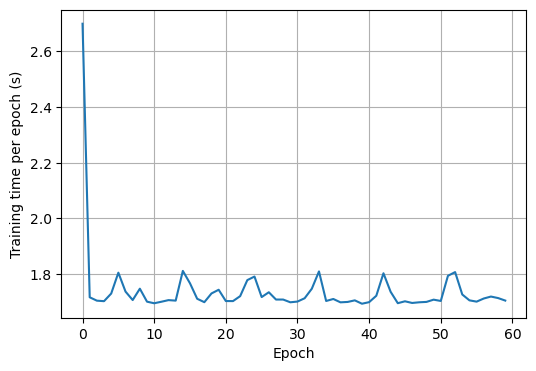

In [83]:
timetaken = timecallback()

# fit the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=64,
                     # Suppress logging.
                     verbose=0,
                     # use callback to plot training time
                     callbacks = [timetaken])

In [84]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.head(5))
print(hist.tail(5))

       loss  epoch
0  0.002162      0
1  0.000056      1
2  0.000040      2
3  0.000038      3
4  0.000052      4
        loss  epoch
55  0.000032     55
56  0.000032     56
57  0.000032     57
58  0.000032     58
59  0.000032     59


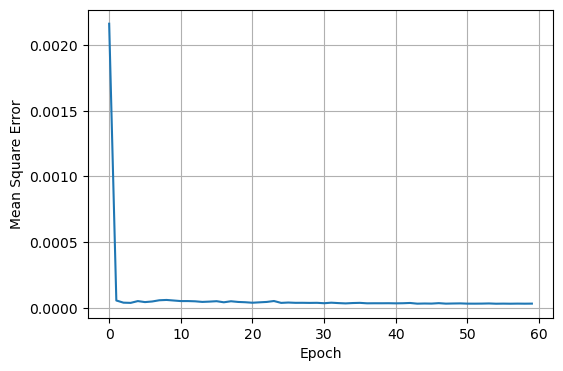

In [85]:
plt.figure(figsize=(6,4))

plt.plot(hist['epoch'], hist['loss'])
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.grid()
plt.show()

In [86]:
mse = model.evaluate(X_test, y_test, verbose=0)
print('RMSE for test set:', math.sqrt(mse))

RMSE for test set: 0.0026628073572940152


In [87]:
mse = model.evaluate(X_train, y_train, verbose=0)
print('RMSE for train set:', math.sqrt(mse))

RMSE for train set: 0.005285360802772627


In [88]:
preds = model.predict(X_test)

10/10 [==============================] - 0s 1ms/step


In [89]:
# inverse transformation
preds_real = min_max_scaler.inverse_transform(preds)
y_test_real = min_max_scaler.inverse_transform(y_test)
preds_real[:5]

array([[672.453],
       [672.469],
       [672.651],
       [672.28 ],
       [672.221]], dtype=float32)

In [90]:
y_test_real[:5]

array([[672.38],
       [672.5 ],
       [672.3 ],
       [672.2 ],
       [672.1 ]])

In [91]:
rmse = tf.keras.metrics.RootMeanSquaredError()
print('RMSE for test set without scaling:', rmse(y_test_real, preds_real))

RMSE for test set without scaling: tf.Tensor(0.2417807, shape=(), dtype=float32)


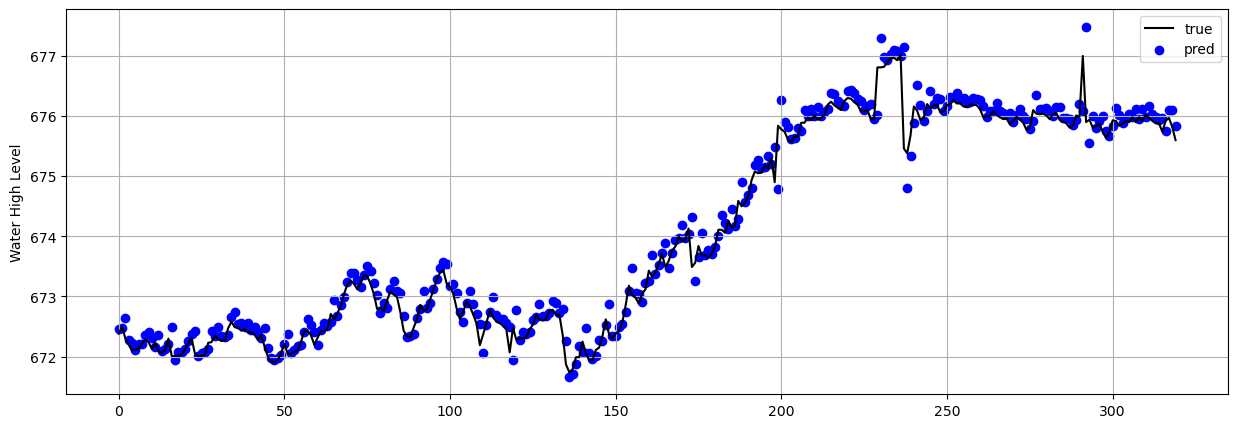

In [92]:
x = tf.linspace(0.0, len(y_test)-1, len(y_test))
plt.figure(figsize=(15,5))
plt.plot(x, y_test_real, label='true', color='black')
plt.scatter(x, preds_real, label='pred', color='blue')
plt.ylabel('Water High Level')
plt.grid()
plt.legend()
plt.show()